In [1]:
import pickle
import json
import cdsapi
import datetime
from datetime import date
import time
import io
import itertools
import requests
import scipy.stats
import warnings
import numpy as np
import pandas as pd
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose 
import seaborn as sn
from sklearn import svm
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

Using TensorFlow backend.


In [2]:
today = date.today()
todaydate = today.strftime('%Y-%m-%d') 

In [3]:
#dates = pd.date_range(start="2021-01-12",end=todaydate).strftime('%Y%m%d').tolist()
dates = pd.bdate_range(start="2021-01-12", end=todaydate, freq='B', weekmask=None).strftime('%Y%m%d').tolist()

In [4]:
results = pd.DataFrame()
for i in dates:
    try: 
        MY_EXCEL_URL="https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_%s.ods"%(i)
        temp_df = pd.read_excel(MY_EXCEL_URL, engine="odf", header=0, skipfooter=0)
        results = results.append(temp_df, sort=True).reset_index(drop=True)
    except: 
        pass

In [5]:
def transVaccineData(a):
    A = a.rename(columns = {'Fecha de la última vacuna registrada (2)': 'fecha', 'Unnamed: 0': 'CCAA', 'Dosis administradas (2)' : 'Doses'}, inplace = False)
    A = A.set_index('fecha')
    A = A[["CCAA", "Nº Personas con al menos 1 dosis", 'Nº Personas vacunadas(pauta completada)', 'Doses']]
    FINAL = A[:-1] #we don't need the final row (count(*))
    return FINAL

def chooseCCAA(CCAA):
    vac = vaccines.loc[vaccines['CCAA'] == CCAA]
    return vac

def doses(A):
    B = A.drop(['CCAA', 'Nº Personas con al menos 1 dosis', 'Nº Personas vacunadas(pauta completada)'], axis=1)
    return B

def immunized(A):
    B = A.drop(['CCAA', 'Doses', 'Nº Personas con al menos 1 dosis'], axis=1)
    return B

def covid_data(a):
    url_covid="https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv"
    s=requests.get(url_covid).content
    data_covid_Spain=pd.read_csv(io.StringIO(s.decode('utf-8')))
    return data_covid_Spain.loc[data_covid_Spain['provincia_iso'] == a]

def covidcleandata(dataframe):
    dataframe.index = dataframe.fecha
    dataframe1 = dataframe.drop(["provincia_iso", 'fecha', 'num_casos_prueba_pcr', "num_casos_prueba_test_ac", "num_casos_prueba_ag", "num_casos_prueba_elisa", "num_casos_prueba_desconocida"], axis=1)
    return dataframe1

In [6]:
vaccines = transVaccineData(results)
vaccines

,CCAA,Nº Personas con al menos 1 dosis,Nº Personas vacunadas(pauta completada),Doses
fecha,,,,
2021-01-11,Andalucía,NaN,NaN,94879.0
2021-01-11,Aragón,NaN,NaN,11983.0
2021-01-12,Asturias,NaN,NaN,22428.0
2021-01-11,Baleares,NaN,NaN,4835.0
2021-01-12,Canarias,NaN,NaN,15328.0
...,...,...,...,...
2021-06-03,Navarra,279121.0,158990.0,425055.0
2021-06-03,País Vasco,955818.0,523402.0,1438333.0
2021-06-03,Ceuta,31206.0,13605.0,43385.0


In [7]:
vaccines.tail(20)

,CCAA,Nº Personas con al menos 1 dosis,Nº Personas vacunadas(pauta completada),Doses
fecha,,,,
2021-06-03,Andalucía,3337630.0,1780256.0,5056835.0
2021-06-03,Aragón,582195.0,314347.0,884547.0
2021-06-03,Asturias,514030.0,303820.0,805334.0
2021-06-03,Baleares,400350.0,174170.0,566241.0
2021-06-03,Canarias,815230.0,371089.0,1144916.0
2021-06-03,Cantabria,256056.0,137943.0,387992.0
2021-06-03,Castilla y Leon,1094311.0,687044.0,1748239.0
2021-06-03,Castilla La Mancha,847837.0,443296.0,1260567.0
2021-06-03,Cataluña,2940765.0,1582303.0,4475002.0


In [8]:
list(vaccines['CCAA']. unique())

['Andalucía',
 'Aragón',
 'Asturias ',
 'Baleares',
 'Canarias',
 'Cantabria',
 'Castilla y Leon ',
 'Castilla La Mancha',
 'Cataluña',
 'C. Valenciana',
 'Extremadura',
 'Galicia',
 'La Rioja',
 'Madrid',
 'Murcia ',
 'Navarra',
 'País Vasco',
 'Ceuta',
 'Melilla',
 'Totales',
 'Fuerzas Armadas',
 nan,
 'Debido a un error en el procesamiento de los datos, el informe correspondiente al día 3 de mayo contenía cifras de vacunación incorrectas, inferiores en su conjunto a los datos reales. Se ha publicado hoy el fichero ODS correspondiente al 3 de mayo con los datos correctos, que puede consultarse en https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_20210503.ods ',
 'C. Valenciana*',
 '*Datos de Comunidad Valenciana pendientes de consolidar',
 '*Datos de Comunidad Valenciana del 21/05']

In [9]:
vacCAT = chooseCCAA('Cataluña')
numpeoplimmuneCAT = immunized(vacCAT)
vacMadrid = chooseCCAA('Madrid')
numpeoplimmuneMadrid = immunized(vacMadrid)
vacAndalucia = chooseCCAA('Andalucía')
numpeoplimmuneAndalucia = immunized(vacAndalucia)

In [10]:
CasesBarcelona = covid_data('B')
CasesBarcelona = covidcleandata(CasesBarcelona)
CasesMadrid = covid_data('M')
CasesMadrid = covidcleandata(CasesMadrid)
CasesMalaga = covid_data('MA')
CasesMalaga = covidcleandata(CasesMalaga)

In [43]:
CasesVizcaya = covid_data('BI')
CasesVizcaya = covidcleandata(CasesVizcaya)

vacPV = chooseCCAA('País Vasco')
numpeoplimmunePV = immunized(vacPV)


<AxesSubplot:xlabel='fecha'>

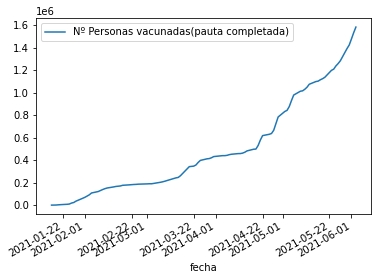

In [11]:
numpeoplimmuneCAT.plot()

<AxesSubplot:xlabel='fecha'>

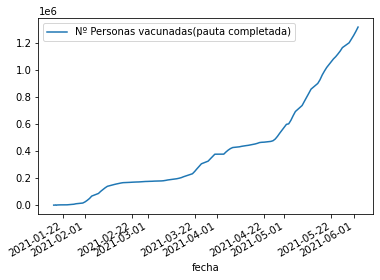

In [12]:
numpeoplimmuneMadrid.plot()

<AxesSubplot:xlabel='fecha'>

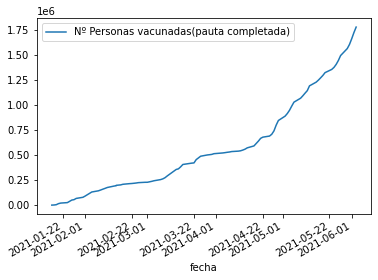

In [13]:
numpeoplimmuneAndalucia.plot()

<AxesSubplot:xlabel='fecha'>

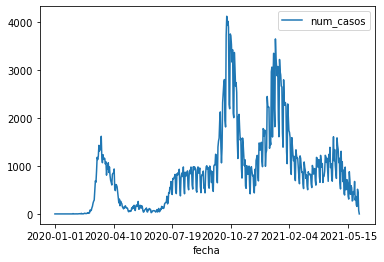

In [14]:
CasesBarcelona.plot()

In [15]:
numpeoplimmuneCAT

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-10,NaN
2021-01-12,NaN
2021-01-13,NaN
2021-01-14,NaN
2021-01-17,167.0
...,...
2021-05-30,1391262.0
2021-05-31,1423308.0
2021-06-01,1477035.0


In [16]:
CasesBarcelona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 2020-01-01 to 2021-06-03
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   num_casos  520 non-null    int64
dtypes: int64(1)
memory usage: 8.1+ KB


In [17]:
numpeoplimmuneCAT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2021-01-10 to 2021-06-03
Data columns (total 1 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Nº Personas vacunadas(pauta completada)  97 non-null     float64
dtypes: float64(1)
memory usage: 1.6 KB


In [18]:
numpeoplimmuneCAT

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-10,NaN
2021-01-12,NaN
2021-01-13,NaN
2021-01-14,NaN
2021-01-17,167.0
...,...
2021-05-30,1391262.0
2021-05-31,1423308.0
2021-06-01,1477035.0


In [19]:
INI = numpeoplimmuneCAT.index[-1].strftime('%Y-%m-%d') 
FIN = numpeoplimmuneCAT.index[0].strftime('%Y-%m-%d') 

In [20]:
date_range = pd.DataFrame({'fecha': pd.date_range(date(2021,1,10), date.today(), freq='D')})
date_range 

,fecha
0,2021-01-10
1,2021-01-11
2,2021-01-12
3,2021-01-13
4,2021-01-14
...,...
142,2021-06-01
143,2021-06-02
144,2021-06-03
145,2021-06-04


In [21]:
TEST = numpeoplimmuneCAT.reset_index()

In [22]:
numpeoplimmuneCAT

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-10,NaN
2021-01-12,NaN
2021-01-13,NaN
2021-01-14,NaN
2021-01-17,167.0
...,...
2021-05-30,1391262.0
2021-05-31,1423308.0
2021-06-01,1477035.0


In [23]:
NEWBCN = date_range.merge(TEST, how='left', on='fecha').set_index('fecha')

In [24]:
NEWBCN

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-10,NaN
2021-01-11,NaN
2021-01-12,NaN
2021-01-13,NaN
2021-01-14,NaN
...,...
2021-06-01,1477035.0
2021-06-02,1532387.0
2021-06-03,1582303.0


In [25]:
pd.set_option("max_rows", None)
CasesBarcelona['2021-01-17':'2021-05-26'] 

,num_casos
fecha,
2021-01-17,1608
2021-01-18,3219
2021-01-19,2972
2021-01-20,2896
2021-01-21,2666
2021-01-22,2645
2021-01-23,1687
2021-01-24,1391
2021-01-25,2795


In [26]:
pd.set_option("max_rows", None)
NEWBCNTEST = NEWBCN['2021-01-17':'2021-05-26']
NEWBCNTEST

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-17,167.0
2021-01-18,432.0
2021-01-19,913.0
2021-01-20,2598.0
2021-01-21,4101.0
2021-01-22,NaN
2021-01-23,NaN
2021-01-24,7472.0
2021-01-25,9620.0


In [27]:
NEWBCNTEST = NEWBCNTEST[~NEWBCNTEST.index.duplicated(keep='first')]

In [28]:
NEWBCNTEST = NEWBCNTEST.fillna(method='ffill')

In [29]:
NEWBCNTEST

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-17,167.0
2021-01-18,432.0
2021-01-19,913.0
2021-01-20,2598.0
2021-01-21,4101.0
2021-01-22,4101.0
2021-01-23,4101.0
2021-01-24,7472.0
2021-01-25,9620.0


In [30]:
CCB = CasesBarcelona['2021-01-17':'2021-05-26']
CCB.index = pd.to_datetime(CCB.index)
NEWBCNTEST.index = pd.to_datetime(NEWBCNTEST.index)

In [31]:
VACvsCC_Barcelona_Cat = CCB.join(NEWBCNTEST, how='outer')
VACvsCC_Barcelona_Cat

,num_casos,Nº Personas vacunadas(pauta completada)
fecha,,
2021-01-17,1608,167.0
2021-01-18,3219,432.0
2021-01-19,2972,913.0
2021-01-20,2896,2598.0
2021-01-21,2666,4101.0
2021-01-22,2645,4101.0
2021-01-23,1687,4101.0
2021-01-24,1391,7472.0
2021-01-25,2795,9620.0


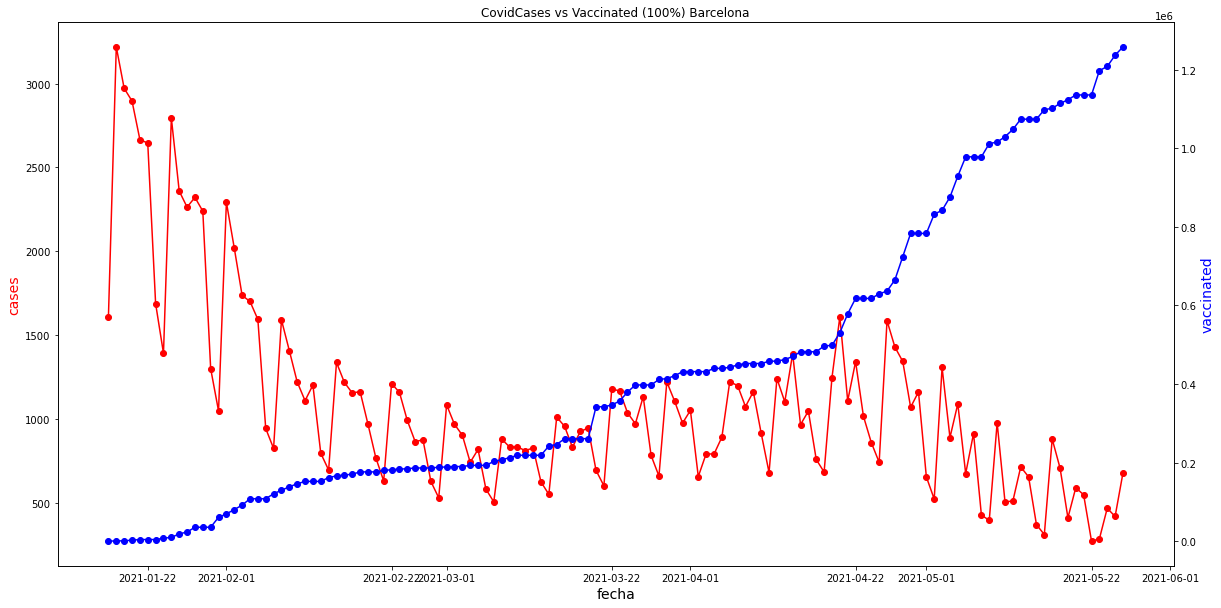

In [55]:
plt.rcParams.update({'figure.figsize': (20,10)})
fig,ax = plt.subplots()

ax.plot(VACvsCC_Barcelona_Cat.index, VACvsCC_Barcelona_Cat.num_casos, color="red", marker="o")

ax.set_xlabel("fecha",fontsize=14)

ax.set_ylabel("cases",color="red",fontsize=14)

ax2=ax.twinx()

ax2.plot(VACvsCC_Barcelona_Cat.index, VACvsCC_Barcelona_Cat['Nº Personas vacunadas(pauta completada)'],color="blue",marker="o")
ax2.set_ylabel("vaccinated",color="blue",fontsize=14)


plt.title("CovidCases vs Vaccinated (100%) Barcelona")
plt.show()

In [33]:
TEST = numpeoplimmuneMadrid.reset_index()
NEWMADRID = date_range.merge(TEST, how='left', on='fecha').set_index('fecha')

In [34]:
CCM = CasesMadrid['2021-01-17':'2021-05-26'] 
NEWMADTEST = NEWMADRID['2021-01-17':'2021-05-26']
NEWMADTEST = NEWMADTEST[~NEWMADTEST.index.duplicated(keep='first')]
NEWMADTEST = NEWMADTEST.fillna(method='ffill')

In [35]:
CCM.index = pd.to_datetime(CCM.index)
NEWMADTEST.index = pd.to_datetime(NEWMADTEST.index)

In [36]:
VACvsCC_Madrid = CCM.join(NEWMADTEST, how='outer')
VACvsCC_Madrid

,num_casos,Nº Personas vacunadas(pauta completada)
fecha,,
2021-01-17,3044,NaN
2021-01-18,5835,476.0
2021-01-19,6983,719.0
2021-01-20,4855,1738.0
2021-01-21,4145,2263.0
2021-01-22,6234,2263.0
2021-01-23,3866,2263.0
2021-01-24,3002,2634.0
2021-01-25,4901,4073.0


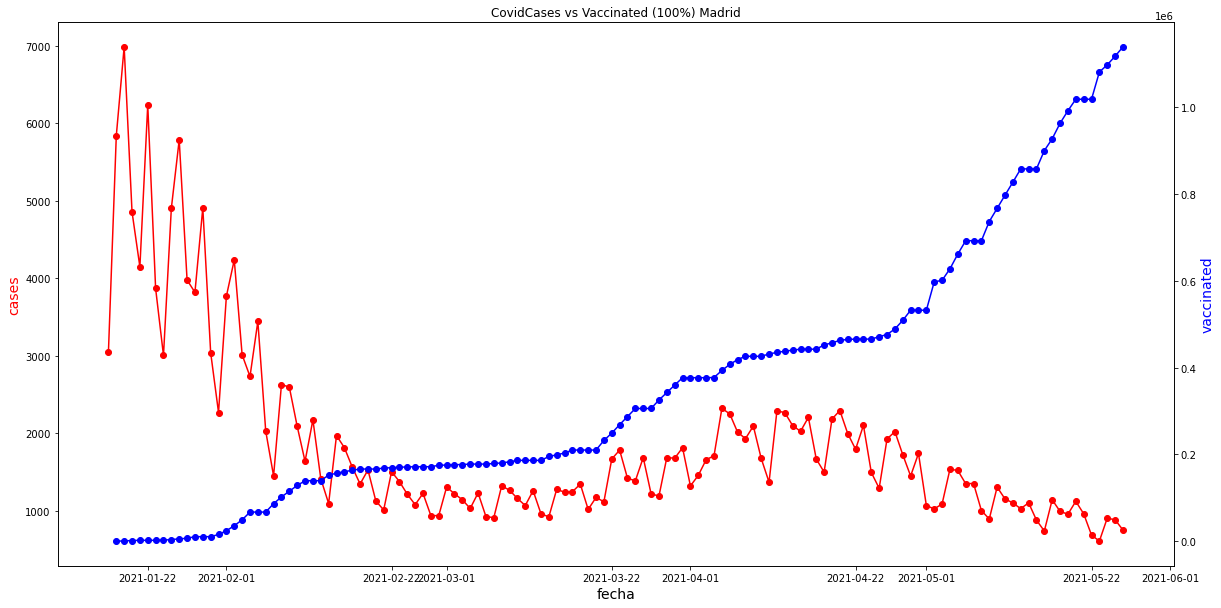

In [54]:
plt.rcParams.update({'figure.figsize': (20,10)})
fig,ax = plt.subplots()

ax.plot(VACvsCC_Madrid.index, VACvsCC_Madrid.num_casos, color="red", marker="o")

ax.set_xlabel("fecha",fontsize=14)

ax.set_ylabel("cases",color="red",fontsize=14)

ax2=ax.twinx()

ax2.plot(VACvsCC_Madrid.index, VACvsCC_Madrid['Nº Personas vacunadas(pauta completada)'],color="blue",marker="o")
ax2.set_ylabel("vaccinated",color="blue",fontsize=14)

plt.title("CovidCases vs Vaccinated (100%) Madrid")
plt.show()

In [38]:
TEST = numpeoplimmuneAndalucia.reset_index()
NEWMALAGA = date_range.merge(TEST, how='left', on='fecha').set_index('fecha')

In [39]:
CCM = CasesMalaga['2021-01-17':'2021-05-26'] 
NEWMALTEST = NEWMALAGA['2021-01-17':'2021-05-26']
NEWMALTEST = NEWMALTEST[~NEWMALTEST.index.duplicated(keep='first')]
NEWMALTEST = NEWMALTEST.fillna(method='ffill')

In [40]:
CCM.index = pd.to_datetime(CCM.index)
NEWMALTEST.index = pd.to_datetime(NEWMADTEST.index)

In [41]:
VACvsCC_Malaga = CCM.join(NEWMALTEST, how='outer')
VACvsCC_Malaga

,num_casos,Nº Personas vacunadas(pauta completada)
fecha,,
2021-01-17,957,533.0
2021-01-18,1510,1773.0
2021-01-19,1757,4568.0
2021-01-20,1861,15193.0
2021-01-21,1481,20846.0
2021-01-22,1696,20846.0
2021-01-23,1378,20846.0
2021-01-24,989,25516.0
2021-01-25,1374,37978.0


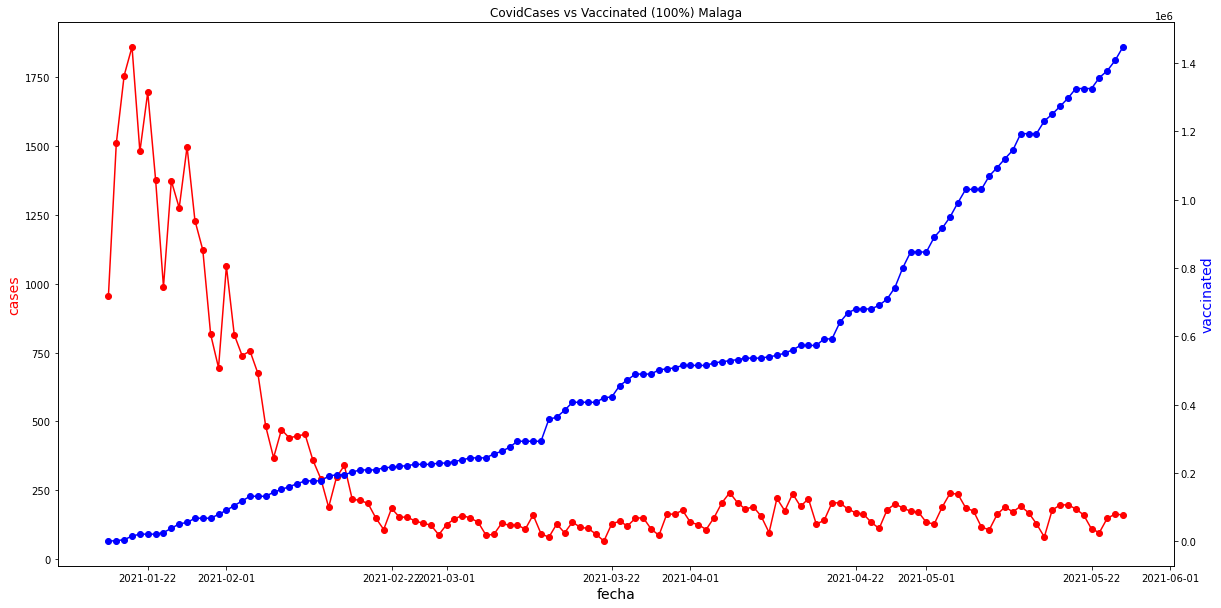

In [53]:
plt.rcParams.update({'figure.figsize': (20,10)})
fig,ax = plt.subplots()

ax.plot(VACvsCC_Malaga.index, VACvsCC_Malaga.num_casos, color="red", marker="o")

ax.set_xlabel("fecha",fontsize=14)

ax.set_ylabel("cases",color="red",fontsize=14)

ax2=ax.twinx()

ax2.plot(VACvsCC_Malaga.index, VACvsCC_Malaga['Nº Personas vacunadas(pauta completada)'],color="blue",marker="o")
ax2.set_ylabel("vaccinated",color="blue",fontsize=14)

plt.title("CovidCases vs Vaccinated (100%) Malaga")
plt.show()

In [45]:
CCBI = CasesVizcaya['2021-01-17':'2021-06-03']
CCBI.index = pd.to_datetime(CCBI.index)

In [46]:
TESTBI = numpeoplimmunePV.reset_index()
NEWPV = date_range.merge(TESTBI, how='left', on='fecha').set_index('fecha')

In [47]:
NEWPV

,Nº Personas vacunadas(pauta completada)
fecha,
2021-01-10,NaN
2021-01-11,NaN
2021-01-12,NaN
2021-01-13,NaN
2021-01-14,NaN
2021-01-15,NaN
2021-01-16,NaN
2021-01-17,0.0
2021-01-18,390.0


In [48]:
NEWPV = NEWPV.fillna(method='ffill')

In [49]:
CCBI

,num_casos
fecha,
2021-01-17,435
2021-01-18,528
2021-01-19,511
2021-01-20,615
2021-01-21,427
2021-01-22,541
2021-01-23,457
2021-01-24,547
2021-01-25,621


In [50]:
VACvsCC_BI = CCM.join(NEWPV, how='outer')
VACvsCC_BI

,num_casos,Nº Personas vacunadas(pauta completada)
fecha,,
2021-01-10,NaN,NaN
2021-01-11,NaN,NaN
2021-01-12,NaN,NaN
2021-01-13,NaN,NaN
2021-01-14,NaN,NaN
2021-01-15,NaN,NaN
2021-01-16,NaN,NaN
2021-01-17,957.0,0.0
2021-01-18,1510.0,390.0


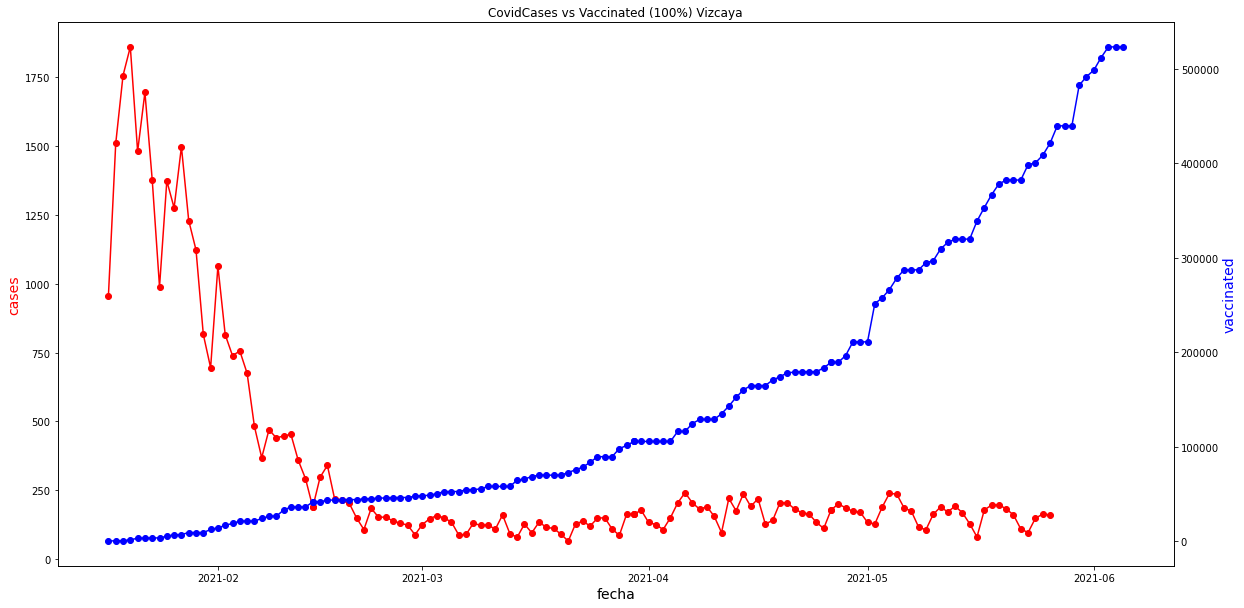

In [51]:
plt.rcParams.update({'figure.figsize': (20,10)})
fig,ax = plt.subplots()

ax.plot(VACvsCC_BI.index, VACvsCC_BI.num_casos, color="red", marker="o")

ax.set_xlabel("fecha",fontsize=14)

ax.set_ylabel("cases",color="red",fontsize=14)

ax2=ax.twinx()

ax2.plot(VACvsCC_BI.index, VACvsCC_BI['Nº Personas vacunadas(pauta completada)'],color="blue",marker="o")
ax2.set_ylabel("vaccinated",color="blue",fontsize=14)
plt.title("CovidCases vs Vaccinated (100%) Vizcaya")
plt.show()